# Import Modules

In [4]:
%load_ext autoreload
%autoreload 2

import os
import sys  
import glob
import ray
import logging
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 


from matplotlib.backends.backend_pdf import PdfPages
from tqdm.notebook import tqdm, trange
from scipy import interpolate 
from scipy import signal
from scipy.signal import medfilt

from pathlib import Path
sys.path.append(str(Path('.').absolute().parent.parent))
from util.paths import find, list_subdirs
import io_dict_to_hdf5 as ioh5



import matplotlib as mpl
mpl.rcParams.update({'font.size':         24,
                     'axes.linewidth':    3,
                     'xtick.major.size':  5,
                     'xtick.major.width': 2,
                     'ytick.major.size':  5,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False, 
                     'font.sans-serif':  "Arial",
                     'font.family':      "sans-serif",
                    })
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import platform
if platform.system() == 'Linux':
    base_path = Path('~/NewMonster/T/BinocOptoPreyCapture/').expanduser()
    print('Running on Linux')
else:
    base_path = Path('T:/BinocOptoPreyCapture').expanduser()
    print('Running on Windows')
    
########## Checks if path exists, if not then creates directory ##########
def check_path(basepath, path):
    ''' Created by Elliott Abe '''
    if path in basepath.as_posix():
        return basepath
    elif not (basepath / path).exists():
        (basepath / path).mkdir(exist_ok=True,parents=True)
        print('Added Directory:'+ (basepath / path).as_posix())
        return (basepath / path)
    else:
        return (basepath / path)


url = ray.init(#address='auto',
    # include_dashboard=True,
    ignore_reinit_error=True,
    logging_level=logging.ERROR,)
url

Running on Windows


{'node_ip_address': '127.0.0.1',
 'raylet_ip_address': '127.0.0.1',
 'redis_address': '127.0.0.1:6379',
 'object_store_address': 'tcp://127.0.0.1:65451',
 'raylet_socket_name': 'tcp://127.0.0.1:59769',
 'webui_url': '127.0.0.1:8265',
 'session_dir': 'C:\\Users\\NIELLL~1\\AppData\\Local\\Temp\\ray\\session_2022-01-25_16-09-46_602882_17092',
 'metrics_export_port': 63507,
 'node_id': 'dd65d52e38e3e67e331230a64b920bc003f00e288785bfbdc550e2ac'}

In [5]:

from asyncio import Event
from typing import Tuple

# For typing purposes
from ray.actor import ActorHandle

# ProgressBar
@ray.remote
class ProgressBarActor:
    counter: int
    delta: int
    event: Event

    def __init__(self) -> None:
        self.counter = 0
        self.delta = 0
        self.event = Event()

    def update(self, num_items_completed: int) -> None:
        """Updates the ProgressBar with the incremental
        number of items that were just completed.
        """
        self.counter += num_items_completed
        self.delta += num_items_completed
        self.event.set()

    async def wait_for_update(self) -> Tuple[int, int]:
        """Blocking call.

        Waits until somebody calls `update`, then returns a tuple of
        the number of updates since the last call to
        `wait_for_update`, and the total number of completed items.
        """
        await self.event.wait()
        self.event.clear()
        saved_delta = self.delta
        self.delta = 0
        return saved_delta, self.counter

    def get_counter(self) -> int:
        """
        Returns the total number of complete items.
        """
        return self.counter

class ProgressBar:
    progress_actor: ActorHandle
    total: int
    description: str
    pbar: tqdm

    def __init__(self, total: int, description: str = ""):
        # Ray actors don't seem to play nice with mypy, generating
        # a spurious warning for the following line,
        # which we need to suppress. The code is fine.
        self.progress_actor = ProgressBarActor.remote()  # type: ignore
        self.total = total
        self.description = description

    @property
    def actor(self) -> ActorHandle:
        """Returns a reference to the remote `ProgressBarActor`.

        When you complete tasks, call `update` on the actor.
        """
        return self.progress_actor

    def print_until_done(self) -> None:
        """Blocking call.

        Do this after starting a series of remote Ray tasks, to which you've
        passed the actor handle. Each of them calls `update` on the actor.
        When the progress meter reaches 100%, this method returns.
        """
        pbar = tqdm(desc=self.description, total=self.total)
        while True:
            delta, counter = ray.get(self.actor.wait_for_update.remote())
            pbar.update(delta)
            if counter >= self.total:
                pbar.close()
                return
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def add_colorbar(mappable,linewidth=2):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax, drawedges=False)
    cbar.outline.set_linewidth(linewidth)
    plt.sca(last_axes)
    return cbar

cmap_name = 'Accent'

In [6]:
def get_laser_onoff(imufile,laser_ksize=3):
    imu_data = xr.open_dataset(imufile)
    LaserT = imu_data.IMU_data.sample.data # imu timestamps
    LaserT0 = LaserT[0]
    LaserT = LaserT - LaserT0
    laser = imu_data.IMU_data.sel(channel='acc_x_raw').data # imu dample data
    dlaser = np.diff(medfilt(laser, kernel_size=laser_ksize),append=0)
    l_inds = np.where((np.abs(dlaser)>1.5))[0]
    LOn_ind = l_inds[0]
    LOff_ind = l_inds[-1]
    return LOn_ind, LOff_ind, LaserT

# Load all data

In [ ]:
SavePath = check_path(Path(r'T:\\BinocOptoPreyCapture\\'),'Data')
df_all = pd.read_feather(SavePath/'df_all.feather')
df_all = df_all.set_index(['experiment_date','animal_name','Trial'])
df_meta = pd.read_feather(SavePath/'df_meta.feather') # Per trial data
df = df_all.dropna() # Wtihin trial data

In [40]:
# How to extract single trial data
n=150
trial = df_meta['Trial'].iloc[n]
date = df_meta['experiment_date'].iloc[n]
ani = df_meta['animal_name'].iloc[n]
lon = df_meta['LaserOnInd'].iloc[n]
loff = df_meta['LaserOffInd'].iloc[n]
print('{}, {}, {}, {}'.format(n,date,ani,trial))
mx = df.xs((date,ani,trial),level=(0,1,2))['Mouse_x'].values # mouse x
my = df.xs((date,ani,trial),level=(0,1,2))['Mouse_y'].values # mouse y
cx = df.xs((date,ani,trial),level=(0,1,2))['Cricket_x'].values # cricket x
cy = df.xs((date,ani,trial),level=(0,1,2))['Cricket_y'].values # cricket y
ang = df.xs((date,ani,trial),level=(0,1,2))['Angle'].values # angle of mouse to cricket
spd = df.xs((date,ani,trial),level=(0,1,2))['Speed'].values # speed of mouse
dist = df.xs((date,ani,trial),level=(0,1,2))['Dist'].values # distance to cricket
t = df.xs((date,ani,trial),level=(0,1,2))['t'].values # time in seconds

df_trial = df_meta[((df_meta['experiment_date']==date)&(df_meta['animal_name']==ani)&(df_meta['Trial']==trial))]
# csv2[(csv2['animal_name']==ani) & (csv2['experiment_date']==date) & (csv2['Trial']==trial)]
df_trial[['animal_name','experiment_date','Trial','CaptureT','MovieT','LaserOnT','LaserOffT','LaserOn','Environment','Exp_Ctrl','Capture','Cap_dur_laser']]

150, 083021, PVCha3black, 1


,animal_name,experiment_date,Trial,CaptureT,MovieT,LaserOnT,LaserOffT,LaserOn,Environment,Exp_Ctrl,Capture,Cap_dur_laser
150,PVCha3black,083021,1,6.15,10.883333,0.049088,9.385549,True,Lsb,Exp,True,True


# Load CSV Files and Meta Data

In [5]:
# csv_filepath = os.path.normpath('T:/OptoPreyCapture/csv_today.csv')
csv_filepath = base_path / 'csv_testing.csv'
csv = pd.read_csv(csv_filepath)
csv['experiment_date'] = pd.to_datetime(csv['experiment_date'],infer_datetime_format=True,format='%m%d%Y').dt.strftime('%m%d%y')
csv = csv.loc[(csv['run_preprocessing'] == True)|(csv['run_ephys_analysis'] == True)]
csv = csv[csv['experiment_outcome']=='good'].reset_index(drop=True)

# Format Pandas Dataframe to have Trial number and Stimulus condition
cols = list(csv.keys()[:-4])
cols.append('Trial')
cols.append('LaserOn')
csv2 = pd.DataFrame(columns=cols)
for ind, row in csv.iterrows():
    for n in range(1, 6):
        if pd.isnull(row['excluded_trials'])==True :
            if 'x' in row['{:d}'.format(n)]:
                capture = False
            else:
                capture = True
            if '*' in row['{:d}'.format(n)]:
                csv2 = csv2.append(row[:-4].append(pd.Series([n, True, capture], index=['Trial', 'LaserOn','Capture'])), ignore_index=True)
            else:
                csv2 = csv2.append(row[:-4].append(pd.Series([n, False, capture], index=['Trial', 'LaserOn','Capture'])), ignore_index=True)
        elif  n in np.array(row['excluded_trials']):
            pass
inds, labels = csv2['Environment'].factorize()

# Initialize to get column names by loading in first trial
n=0
row = csv2.iloc[n]
fname = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5'))[0])
with pd.HDFStore(fname) as store:
    data = store['df']
    metadata = store.get_storer('df').attrs.metadata

In [6]:
# Create metadata dataframe
df_meta = pd.DataFrame(columns=list(metadata.keys()))
for ind, row in tqdm(csv2.iterrows(),total=csv2.shape[0]):
    if list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5')) != []:
        fname = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5'))[0])
        with pd.HDFStore(fname) as store:
            data = store['df']
            metadata = store.get_storer('df').attrs.metadata
            if row['LaserOn']==True:
                if (row['experiment_date'] != '091521') & (row['experiment_date'] != '091621'):
                    imufile = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*imu.nc'))[0])
                    Lon, Loff, LaserT = get_laser_onoff(imufile)
                    metadata['LaserOnInd'] = np.abs(data['t'] - LaserT[Lon]).argmin()
                    metadata['LaserOffInd'] = np.abs(data['t'] - LaserT[Loff]).argmin()
                    metadata['LaserOnT'] = data['t'].values[np.abs(data['t'] - LaserT[Lon]).argmin()]
                    metadata['LaserOffT'] = data['t'].values[np.abs(data['t'] - LaserT[Loff]).argmin()]
                else:
                    metadata['LaserOnInd'] = np.abs(data['t'] - 0).argmin()
                    metadata['LaserOffInd'] = np.abs(data['t'] - 30).argmin()
                    metadata['LaserOnT'] = data['t'].values[np.abs(data['t'] - 0).argmin()]
                    metadata['LaserOffT'] = data['t'].values[np.abs(data['t'] - 30).argmin()]
            else:
                metadata['LaserOnInd'] = -999
                metadata['LaserOffInd'] = -999
            metadata.update(csv2[['animal_name','experiment_date','Trial','LaserOn','Environment','Exp_Ctrl','Capture']].iloc[ind])
            df_meta = df_meta.append(metadata, ignore_index=True)
df_meta = df_meta.astype({'Trial':np.int16,'LaserOn':bool,'LaserOnInd':np.int32,'LaserOffInd':np.int32,'Capture':bool})
# Set Failed Capture Times to nan
# mask = (df_meta['Capture']==False)
# df_meta.loc[mask,'CaptureT'] = np.nan

df_meta['Cap_dur_laser'] = False
mask2=(df_meta['Capture']==True) & (df_meta['CaptureT'] > df_meta['LaserOnT']) & (df_meta['CaptureT'] < df_meta['LaserOffT'])
df_meta.loc[mask2,'Cap_dur_laser'] = True

  0%|          | 0/1310 [00:00<?, ?it/s]

df_meta is a dataframe that contains per trial information. Like Movie length, capture time, type of environment, ect.

In [8]:
df_meta.head()

,MovieT,CaptureT,TimeToApproach,FreqApproach,ProbInter,ProbCapture,dist_at_approach,Capture,Environment,Exp_Ctrl,LaserOffInd,LaserOffT,LaserOn,LaserOnInd,LaserOnT,Trial,animal_name,experiment_date,dist_at_fapproach,Cap_dur_laser
0,68.233333,68.216667,12.770970,0.337079,0.086957,0.500000,"[34.12317660124058, 30.044074850290222, 26.879...",False,Hsb,Exp,1954,32.577383,True,0,0.000000,1,PVCha2black,082521,NaN,False
1,61.216667,61.200000,9.720384,0.245031,0.133333,0.500000,"[25.92030663595594, 11.693279562091062, 24.776...",False,Hsb,Exp,-999,NaN,False,-999,NaN,2,PVCha2black,082521,NaN,False
2,53.666667,52.066667,0.349978,0.428571,0.391304,0.111111,"[14.75392199298944, 6.39213761704472, 39.42353...",True,Hsb,Exp,-999,NaN,False,-999,NaN,3,PVCha2black,082521,NaN,False
3,65.266667,62.383333,2.234432,0.398366,0.500000,0.076923,"[17.50958966131445, 31.508735393227703, 31.627...",True,Hsb,Exp,1927,32.126681,True,0,0.000000,4,PVCha2black,082521,NaN,False
4,70.900000,67.633333,0.867098,0.366714,0.538462,0.071429,"[9.542684210681163, 9.551640095015705, 27.3816...",True,Hsb,Exp,1854,30.909555,True,3,0.049536,5,PVCha2black,082521,NaN,False


## Plotting by Conditions

In [9]:
row = csv2.iloc[0]
fname = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5'))[0])
with pd.HDFStore(fname) as store:
    data = store['df']
    metadata = store.get_storer('df').attrs.metadata
    if row['LaserOn']==True:
        if (row['experiment_date'] != '091521') | (row['experiment_date'] != '091621'):
            imufile = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*imu.nc'))[0])
            Lon, Loff, LaserT = get_laser_onoff(imufile)
            metadata['LaserOnInd'] = data['t'].values[np.abs(data['t'] - LaserT[Lon]).argmin()]
            metadata['LaserOffInd'] = data['t'].values[np.abs(data['t'] - LaserT[Loff]).argmin()]
        else:
            metadata['LaserOnT'] = data['t'].values[np.abs(data['t'] - 0).argmin()]
            metadata['LaserOffT'] = data['t'].values[np.abs(data['t'] - 30).argmin()]

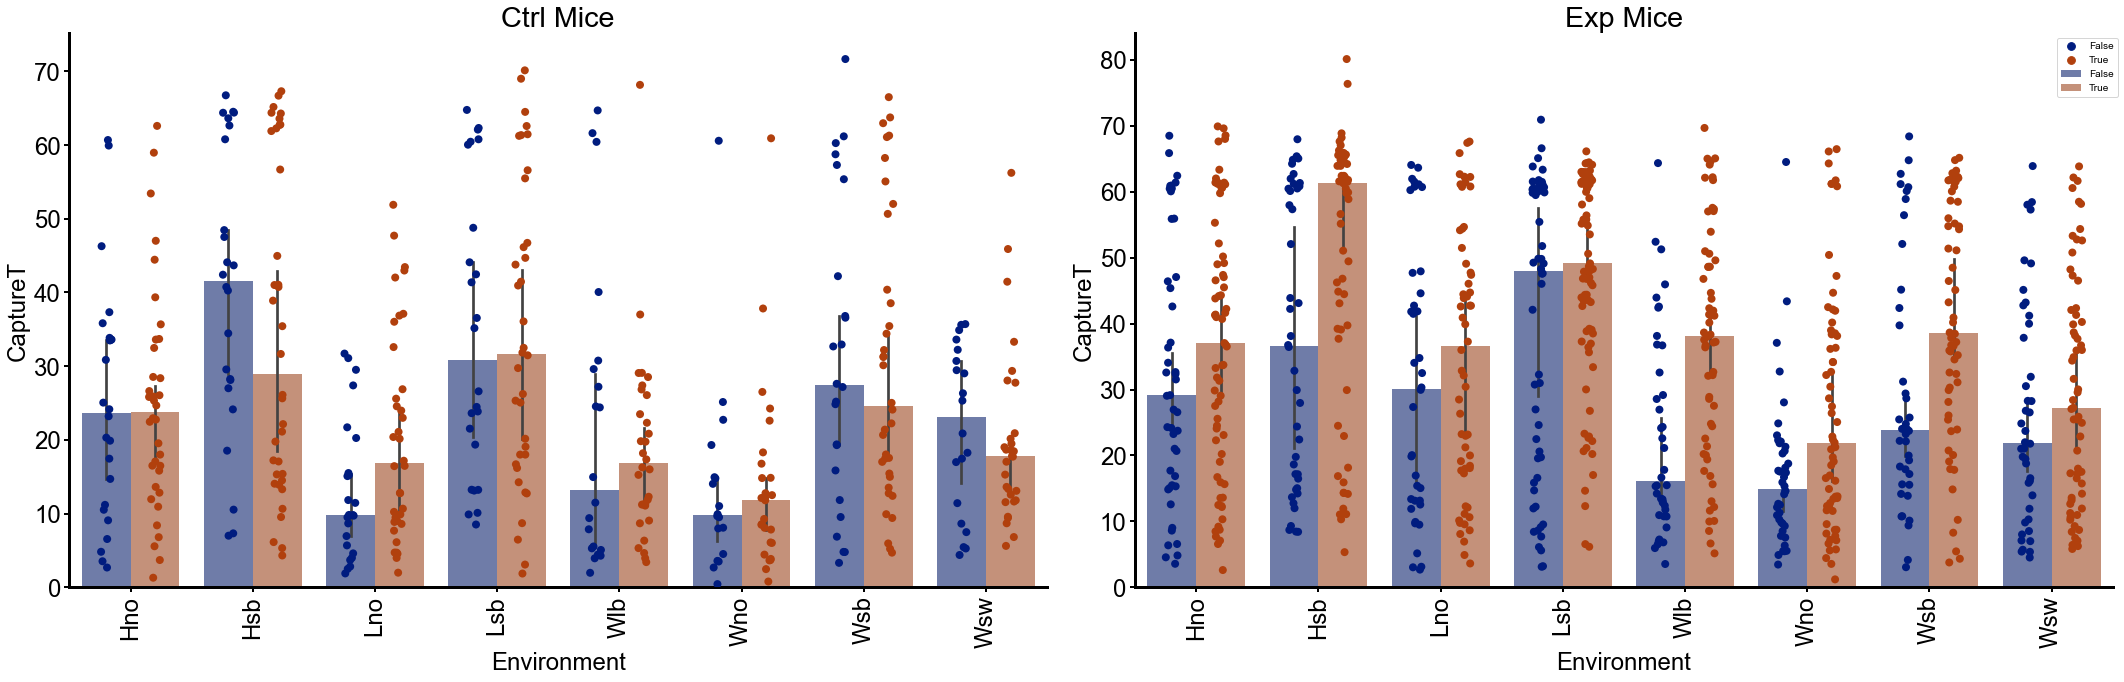

In [10]:
Metric = 'CaptureT'
fig, axs = plt.subplots(1,2,figsize=(30,10))
for ind, cond in enumerate(np.unique(df_meta['Exp_Ctrl'])):
    g = sns.barplot(data=df_meta[df_meta['Exp_Ctrl']==cond], x="Environment", y=Metric, hue="LaserOn", estimator=np.median,
                    palette="dark", alpha=.6, ax=axs[ind],order=sorted(df_meta['Environment'].unique()))
    g.set_xlabel("")
    g.set_ylabel("{}".format(Metric))
    g.set_xticklabels(g.get_xticklabels(), rotation = 90)
    g.set_title('{} Mice'.format(cond))
#     sns.catplot(x="Environment", y=Metric, hue="LaserOn",kind="swarm", data=df_meta[df_meta['Exp_Ctrl']==cond],ax=axs[ind])
    sns.stripplot(x="Environment", y=Metric, hue="LaserOn", data=df_meta[df_meta['Exp_Ctrl']==cond],ax=axs[ind], palette="dark", size=8, dodge=True,order=sorted(df_meta['Environment'].unique()))
    axs[ind].legend([],[], frameon=False)
axs[ind].legend(bbox_to_anchor=(1.01, 1), fontsize=10)
plt.tight_layout()
# fig.savefig(FigPath/(Metric+'_median.png'),facecolor='white', transparent=True)


# Rate of Capture Testing

In [11]:
##### Failure Trials #####
# Laser on Failure Time #
Lon_Fails = ((df_meta[(df_meta['Capture']==False)&(df_meta['LaserOn']==True)][['Environment','Exp_Ctrl','CaptureT','LaserOnT','LaserOffT']]).groupby(['Environment','Exp_Ctrl']).sum())#.reset_index()
Lon_Fails = Lon_Fails.unstack(fill_value=0).stack()
Lon_Fails['LCapT'] = (Lon_Fails['LaserOffT']-Lon_Fails['LaserOnT'])
# Laser Off Failure Time #
Loff_Fails = ((df_meta[(df_meta['Capture']==False)&(df_meta['LaserOn']==False)][['Environment','Exp_Ctrl','CaptureT','LaserOnT','LaserOffT']]).groupby(['Environment','Exp_Ctrl']).sum())#.reset_index()
Loff_Fails = Lon_Fails.unstack(fill_value=0).stack()
Loff_Fails['LCapT'] = (Loff_Fails['CaptureT']-Loff_Fails['LaserOffT'])

##### Success Trials #####
# Captured During Laser On time #
df1 = df_meta[(df_meta['Capture']==True)&(df_meta['Cap_dur_laser']==True)&(df_meta['LaserOn']==True)][['animal_name','Environment','Trial','Exp_Ctrl','CaptureT','LaserOnT','LaserOffT']] # Captured during Laser on
# df1 = df1.unstack(fill_value=0).stack()
df1['LCapT'] = df1['CaptureT'] - df1['LaserOnT'] # amount of time laser on 
# Captured During Laser off Time # 
df2 = df_meta[(df_meta['Capture']==True)&(df_meta['Cap_dur_laser']==False)&(df_meta['LaserOn']==True)][['animal_name','Environment','Trial','Exp_Ctrl','CaptureT','LaserOnT','LaserOffT']] # Captured after laser off
# df2 = df2.unstack(fill_value=0).stack()
df2['LCapT'] = df2['CaptureT'] - df2['LaserOffT'] # amount of time laser off
# Captured during NO Laser Trials 
df3 = df_meta[(df_meta['Capture']==True)&(df_meta['Cap_dur_laser']==False)&(df_meta['LaserOn']==False)][['animal_name','Environment','Trial','Exp_Ctrl','CaptureT']] # Non Laser Caputure
# df3 = df3.unstack(fill_value=0).stack()
df3['LCapT'] = df3['CaptureT'].copy()

##### LaserOnCapture Count #####
Lon_count = df1[['Exp_Ctrl','Environment','LCapT']].groupby(['Environment','Exp_Ctrl']).count()
##### LaserOnCapture Time + LaserOnFail Times #####
Lon_T = (df1[['Exp_Ctrl','Environment','LCapT']].groupby(['Environment','Exp_Ctrl']).sum() + Lon_Fails[['LCapT']])
##### LaserOffCapture Count + NoLaser Count #####
Loff_count = (df2[['Exp_Ctrl','Environment','LCapT']].groupby(['Environment','Exp_Ctrl']).count().unstack(fill_value=0).stack() + df3[['Exp_Ctrl','Environment','LCapT']].groupby(['Environment','Exp_Ctrl']).count())
##### LaserOffCapture Time + LaserOffFails Time + NoLaser Time #####
Loff_T = (df2[['Exp_Ctrl','Environment','LCapT']].groupby(['Environment','Exp_Ctrl']).sum().unstack(fill_value=0).stack()  + Loff_Fails[['LCapT']] + df3[['Exp_Ctrl','Environment','LCapT']].groupby(['Environment','Exp_Ctrl']).sum())

In [12]:
df1b = (Lon_T/Lon_count).reset_index()
df1b['LaserOn'] = True
df2b = (Loff_T/Loff_count).reset_index()
df2b['LaserOn'] = False
df_CapT = pd.concat((df1b,df2b),axis=0)
# df_CapT

Time per capture for each animal then average across animals. errorbars

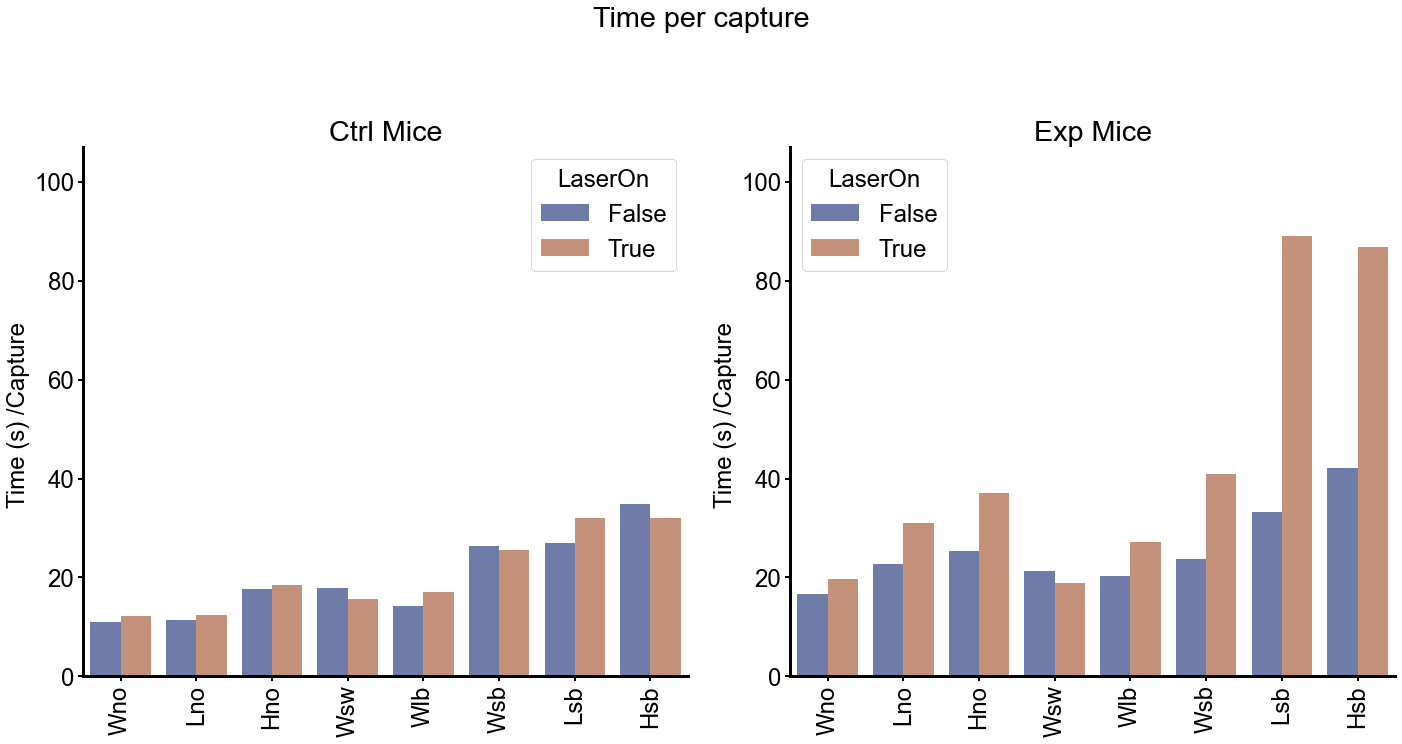

In [13]:
FigPath = check_path(Path('~/Research/PreyCapture/').expanduser(),'Figures/')
order=['Wno','Lno','Hno','Wsw','Wlb','Wsb','Lsb','Hsb',]
Metric = 'LCapT'
fig, axs = plt.subplots(1,2,figsize=(20,10))
for ind, cond in enumerate(np.unique(df_meta['Exp_Ctrl'])):
    g = sns.barplot(data=df_CapT[df_CapT['Exp_Ctrl']==cond], x="Environment", y=Metric, hue="LaserOn", estimator=np.median,
                    ci='sd', palette="dark", alpha=.6, ax=axs[ind],order=order)
    g.set_xlabel("")
    g.set_ylabel("{}".format('Time (s) /Capture '))
    g.set_xticklabels(g.get_xticklabels(), rotation = 90)
    g.set_title('{} Mice'.format(cond))
    g.set_ylim(0, df_CapT['LCapT'].max() + df_CapT['LCapT'].std())#.3)
plt.suptitle('Time per capture',y=1.05)
plt.tight_layout()
# fig.savefig(FigPath/'TimeperCapture.png', facecolor='white', transparent=True)

prob of initiating vs prob of intercept after initiation

distance at approach onset

defining approaches: hmm and jen's method

Trajectory/angle of head at approach. 

Speed during approach 

Angle during approach

body point: displacement of the body as vector. is center point moving towards cricket

distance to the walls. 2d hist of where mice are. 

interp of cricket: interp cricket location based on distance to mouse for kinematic variables. tkae out nan in beginning and end then interp. 

# Within Trial Data: angle, speed, dist. etc.

In [14]:
fname = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5'))[0])
with pd.HDFStore(fname) as store:
    data = store['df'].copy()
    

In [15]:
df_all = pd.DataFrame()
for ind, row in tqdm(df_meta.iterrows(), total=df_meta.shape[0]):
    if list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5')) != []:
        fname = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5'))[0])
        with pd.HDFStore(fname) as store:
            data = store['df']
            data['animal_name'] = row['animal_name']
            data['experiment_date'] = row['experiment_date']
            data['Trial'] = row['Trial']
            data['GroupNum'] = ind
            data['Environment'] = row['Environment']
            # threshold out outlaiers 
            data['Angle'].where(~(data['Angle']>180),np.nan,inplace=True)            
            data['Speed'].where(~(data['Speed']>50),np.nan,inplace=True)            
            data['Dist'].where(~(data['Dist']>50),np.nan,inplace=True)            
            data['Angle_norm'] = data['Angle'].copy()/180
            data['Speed_norm'] = data['Speed'].copy()/50
            data['Dist_norm'] = data['Dist'].copy()/50
            temp_laser = np.zeros((len(data)),dtype=bool)
            if row['LaserOn']==True:
                if (row['experiment_date'] != '091521') & (row['experiment_date'] != '091621'):
                    imufile = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*imu.nc'))[0])
                    Loni, Loffi, LaserT = get_laser_onoff(imufile)
                    Lon = np.abs(data['t'] - LaserT[Loni]).argmin()
                    Loff = np.abs(data['t'] - LaserT[Loffi]).argmin()
                    temp_laser[Lon:Loff]=True
                    data['LaserOn'] = temp_laser
                else:
                    Lon = np.abs(data['t'] - 0).argmin()
                    Loff = np.abs(data['t'] - 30).argmin()
                    temp_laser[Lon:Loff]=True
                    data['LaserOn'] = temp_laser
            else:
                data['LaserOn'] = temp_laser
            if row['Exp_Ctrl'] == 'Exp':
                data['ExpAni'] = True
            else:
                data['ExpAni'] = False
            data.set_index(['experiment_date','animal_name','Trial'],inplace=True)
            df_all = df_all.append(data.copy())


  0%|          | 0/1306 [00:00<?, ?it/s]

In [20]:
h5path = r'T:\BinocOptoPreyCapture\093021\PVCha2black\3\093021_PVCha2black_y_Lsb_3_TOP1DLC_resnet50_BinocularOptoAug12shuffle1_325000.h5'
df1 = pd.read_hdf(h5path)
df1.columns = ['_'.join(col[:][1:]).strip() for col in df1.columns.values]

In [33]:
ncpath = r'T:\BinocOptoPreyCapture\093021\PVCha2black\3\093021_PVCha2black_y_Lsb_3_TOP1.nc'
da1 = xr.open_dataset(ncpath)

In [30]:
np.sum(df1.iloc[:,2::3]<.99),df1.shape

(Nose_likelihood            2
 Lear_likelihood            0
 Rear_likelihood            0
 BackofHead_likelihood      0
 Spine_likelihood           1
 TailBase_likelihood        9
 Cricket1_likelihood      532
 Cricket2_likelihood      557
 TopRight1_likelihood      52
 TopRight2_likelihood      43
 TopLeft1_likelihood        3
 TopLeft2_likelihood       38
 BotLeft1_likelihood       24
 BotLeft2_likelihood        8
 BotRight1_likelihood       8
 BotRight2_likelihood      26
 dtype: int64,
 (2001, 48))

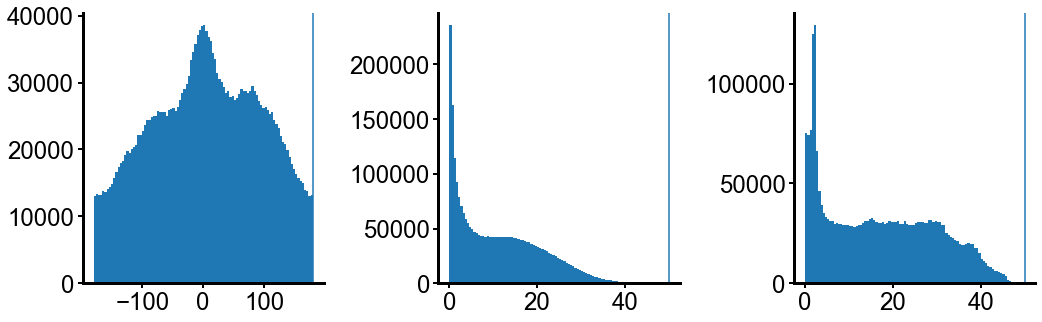

In [18]:
# Histograms for the Thresholding state variables
fig, axs = plt.subplots(1,3, figsize=(15,5))
counts,bins,hist = axs[0].hist(df_all['Angle'],bins=100)
axs[0].axvline(x=180)
counts,bins,hist = axs[1].hist(df_all['Speed'],bins=100)
axs[1].axvline(x=50)
counts,bins,hist = axs[2].hist(df_all['Dist'],bins=100)
axs[2].axvline(x=50)
plt.tight_layout()

Histograms on each condition

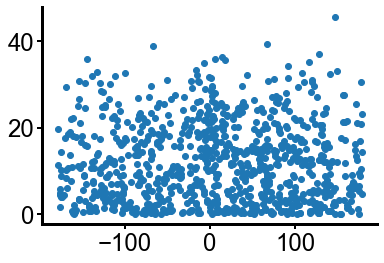

In [26]:
inds = sorted(np.random.choice(np.arange(0,embedding.shape[0]),1000))

plt.scatter(df_all['Angle'].to_numpy()[inds],df_all['Speed'].to_numpy()[inds])

In [131]:
X = df[['Angle_norm','Speed_norm','Dist_norm']].values
X[:,0] = np.abs(X[:,0])
X.shape

(2061787, 3)

## Histograms

In [164]:
df.head()

Angle     Speed       Dist   Mouse_x  \
experiment_date animal_name Trial                                             
082521          PVCha2black 1     -22.951467  0.116312  20.761324  7.571586   
                            1     -22.393889  0.039550  18.985130  7.554922   
                            1      -9.550244  0.182478  12.951043  7.573205   
                            1      -2.750227  0.119839  11.486301  7.566575   
                            1       7.437414  0.048882  10.352051  7.567440   

                                     Mouse_y  Cricket_x  Cricket_y         t  \
experiment_date animal_name Trial                                              
082521          PVCha2black 1      26.037581   6.394965   5.309625  0.468148   
                            1      26.072119   6.899012   7.098323  0.483725   
                            1      26.051174   9.967942  13.323458  0.534656   
                            1      26.042998  11.072731  15.104900  0.551655   
                            1      26.042762  12.297671  16.834621  0.567540   

                                   GroupNum Environment  Angle_norm  \
experiment_date animal_name Trial                                     
082521          PVCha2black 1             0         Hsb   -0.127508   
                            1             0         Hsb   -0.124410   
                            1             0         Hsb   -0.053057   
                            1             0         Hsb   -0.015279   
                            1             0         Hsb    0.041319   

                                   Speed_norm  Dist_norm  LaserOn  ExpAni  
experiment_date animal_name Trial                                          
082521          PVCha2black 1        0.002326   0.415226     True    True  
                            1        0.000791   0.379703     True    True  
                            1        0.003650   0.259021     True    True  
                            1        0.002397   0.229726     True    True  
                            1        0.000978   0.207041     True    True

In [375]:
FigPath = check_path(Path('~/Research/PreyCapture/').expanduser(),'Figures/')

hbins = 100
# Histograms for the Thresholding state variables
metrics = ['Angle','Speed','Dist']
order=['Wno','Lno','Hno','Wsw','Wlb','Wsb','Lsb','Hsb',]

pdf_name = FigPath / 'Metric_Hist_by_Env.pdf'
with PdfPages(pdf_name) as pdf:
    for env in tqdm(order):
        fig, axs = plt.subplots(3,2, figsize=(15,20),sharey='row')
        for n in range(axs.shape[0]):
            for m, Exp in enumerate([True,False]):
                hist_data_Lon = df[(df['ExpAni']==Exp) & (df['LaserOn']==True) & (df['Environment']==env)].reset_index()[metrics[n]]
                hist_data_Loff = df[(df['ExpAni']==Exp) & (df['LaserOn']==False) & (df['Environment']==env)].reset_index()[metrics[n]]
                hbin_edges1 = np.linspace(np.min(hist_data_Lon),np.max(hist_data_Lon),hbins)
                hbin_edges2 = np.linspace(np.min(hist_data_Loff),np.max(hist_data_Loff),hbins)
                count1,edges1 = np.histogram(hist_data_Lon,bins=hbin_edges1)            
                count2,edges2 = np.histogram(hist_data_Loff,bins=hbin_edges2)
                edges_mid1 = np.array([(edges1[i]+edges1[i+1])/2 for i in range(len(edges1)-1)])
                edges_mid2 = np.array([(edges2[i]+edges2[i+1])/2 for i in range(len(edges2)-1)])
                axs[n,m].bar(edges_mid1, count1/hist_data_Lon.shape[0],color='g',width=np.mean(np.diff(hbin_edges1)),alpha=.5, label='LaserOn')
                axs[n,m].bar(edges_mid2, count2/hist_data_Loff.shape[0],color='r',width=np.mean(np.diff(hbin_edges2)),alpha=.5, label='LaserOff')
                axs[n,m].set_xlabel('{}'.format(metrics[n]))
#                 axs[n,m].set_ylim(0,np.max((count1/hist_data_Lon.shape[0],count2/hist_data_Loff.shape[0])))
        axs[0,0].set_title('Exp. Anis')
        axs[0,1].set_title('Ctrl. Anis')
        axs[0,1].legend()
        plt.suptitle(env)
        plt.tight_layout()
        pdf.savefig()
        plt.close()

  0%|          | 0/8 [00:00<?, ?it/s]